In [4]:
import pandas as pd 

df_eng = pd.read_csv("english_essays.csv")


In [5]:
df_eng = df_eng[["score", "full_text"]].dropna()
df_eng.columns = ['essay', 'score']


In [6]:
df_eng = df_eng[['score', 'essay']]


In [7]:
def load_europarl_file(file_path, max_lines=5000):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f.readlines()[:max_lines]]
    return lines

german_texts = load_europarl_file("europarl-v7.de-en.de")
spanish_texts = load_europarl_file("europarl-v7.es-en.es")
french_texts = load_europarl_file("europarl-v7.fr-en.fr")


In [8]:
def create_documents(sentences, doc_len=10):
    return [" ".join(sentences[i:i+doc_len]) for i in range(0, len(sentences) - doc_len, doc_len)]

german_docs = create_documents(german_texts)
spanish_docs = create_documents(spanish_texts)
french_docs = create_documents(french_texts)


In [9]:
import numpy as np
import random

def assign_fake_scores(documents):
    return [random.randint(2, 6) for _ in documents]  # Or use a heuristic

german_scores = assign_fake_scores(german_docs)
spanish_scores = assign_fake_scores(spanish_docs)
french_scores = assign_fake_scores(french_docs)


In [10]:
df_de = pd.DataFrame({'essay': german_docs, 'score': german_scores, 'lang': 'de'})
df_es = pd.DataFrame({'essay': spanish_docs, 'score': spanish_scores, 'lang': 'es'})
df_fr = pd.DataFrame({'essay': french_docs, 'score': french_scores, 'lang': 'fr'})

full_df = pd.concat([df_eng, df_de, df_es, df_fr], ignore_index=True)


In [11]:
!pip install pandas numpy scikit-learn tensorflow


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_NUM_WORDS = 20000    # Max number of unique words to keep
MAX_SEQ_LENGTH = 500     # Max length of each input (in tokens)

# Make sure essays are strings and drop missing ones
full_df['essay'] = full_df['essay'].astype(str)

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(full_df['essay'].values)   # Learn vocabulary

sequences = tokenizer.texts_to_sequences(full_df['essay'].values)  # Convert each text to a list of integers
X = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')  # Pad to fixed length


In [15]:
y = full_df['score'].values


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQ_LENGTH),
    Conv1D(128, 5, activation='relu'),  # 128 filters, 5-word kernel
    GlobalMaxPooling1D(),               # Collapse time dimension
    Dense(64, activation='relu'),       # Fully connected layer
    Dropout(0.5),                       # Regularization
    Dense(1, activation='linear')       # Output: 1 value (score)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          2560000   
                                                                 
 conv1d (Conv1D)             (None, 496, 128)          82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [21]:
import numpy as np

# Step 1: Identify English rows (where lang is NaN)
mask_en = full_df['lang'].isna()

# Step 2: Swap the columns only for those rows
full_df.loc[mask_en, ['score', 'essay']] = full_df.loc[mask_en, ['essay', 'score']].values

# Step 3: Set lang to 'en' for those rows
full_df.loc[mask_en, 'lang'] = 'en'

# Step 4: Convert score to float
full_df['score'] = full_df['score'].astype(np.float32)


In [22]:
full_df

,score,essay,lang
0,4.0,The author suggests that studying Venus is wor...,en
1,2.0,NASA is fighting to be alble to to go to Venus...,en
2,3.0,"""The Evening Star"", is one of the brightest po...",en
3,2.0,The author supports this idea because from rea...,en
4,2.0,How the author supports this idea is that he s...,en
...,...,...,...
26220,2.0,Mais il faut dire aux auteurs de cette questio...,fr
26221,3.0,"Troisièmement, les mesures fiscales peuvent fa...",fr
26222,4.0,"Si lesdites connaissances, le débat et les arg...",fr
26223,6.0,Il importe que nous en connaissions les acteur...,fr


In [23]:
from sklearn.model_selection import train_test_split

# Clean target labels
y = full_df['score'].values.astype(np.float32)

# Split into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)


Epoch 1/10


2025-04-09 01:24:14.814218: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


656/656 [==============================] - 25s 37ms/step - loss: 0.7417 - mae: 0.5863 - val_loss: 0.1392 - val_mae: 0.1523
Epoch 2/10
656/656 [==============================] - 24s 36ms/step - loss: 0.3725 - mae: 0.4423 - val_loss: 0.1663 - val_mae: 0.2488
Epoch 3/10
656/656 [==============================] - 24s 36ms/step - loss: 0.3050 - mae: 0.4009 - val_loss: 0.1517 - val_mae: 0.1294
Epoch 4/10
656/656 [==============================] - 24s 37ms/step - loss: 0.2600 - mae: 0.3635 - val_loss: 0.1460 - val_mae: 0.1567
Epoch 5/10
656/656 [==============================] - 27s 42ms/step - loss: 0.2128 - mae: 0.3226 - val_loss: 0.1699 - val_mae: 0.1975
Epoch 6/10
656/656 [==============================] - 26s 40ms/step - loss: 0.1701 - mae: 0.2852 - val_loss: 0.1520 - val_mae: 0.1468
Epoch 7/10
656/656 [==============================] - 27s 40ms/step - loss: 0.1424 - mae: 0.2548 - val_loss: 0.1516 - val_mae: 0.1427
Epoch 8/10
656/656 [==============================] - 30s 45ms/step - los

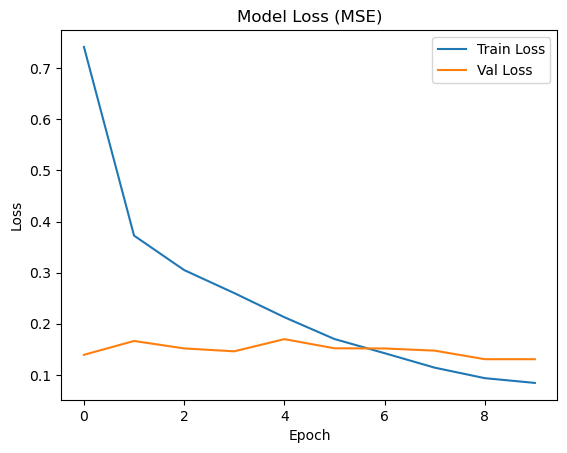

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


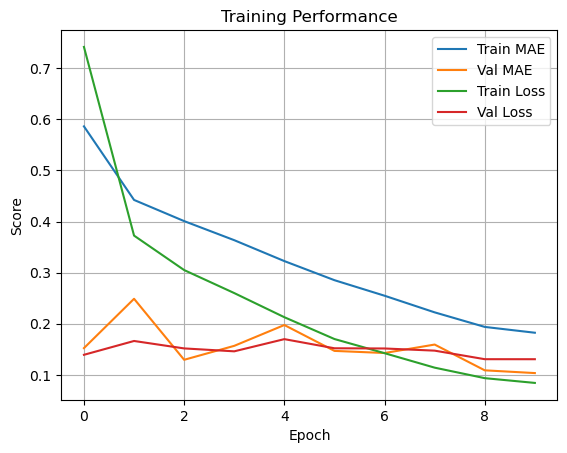

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training Performance')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
y_pred = model.predict(X_val).flatten()

# Compare actual vs predicted
import numpy as np

for i in range(5):
    print(f"Predicted: {round(y_pred[i], 2)}, Actual: {y_val[i]}")


164/164 [==============================] - 1s 9ms/step
Predicted: 3.9700000286102295, Actual: 4.0
Predicted: 2.0199999809265137, Actual: 2.0
Predicted: 3.9800000190734863, Actual: 2.0
Predicted: 3.0199999809265137, Actual: 3.0
Predicted: 3.9700000286102295, Actual: 4.0


In [29]:
rounded_preds = np.round(y_pred)
accuracy = np.mean(rounded_preds == y_val)
print(f"Exact match accuracy: {accuracy:.2%}")

Exact match accuracy: 95.41%


In [30]:
within_1 = np.mean(np.abs(rounded_preds - y_val) <= 1)
print(f"Accuracy within ±1 point: {within_1:.2%}")


Accuracy within ±1 point: 97.58%


In [31]:
from sklearn.preprocessing import OneHotEncoder

# Create One-Hot Encoder
lang_encoder = OneHotEncoder(sparse=False)

# Reshape lang column and fit_transform
lang_features = lang_encoder.fit_transform(full_df[['lang']])


/Users/rajeev/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [32]:
from sklearn.model_selection import train_test_split

X_train_text, X_val_text, y_train, y_val, X_train_lang, X_val_lang = train_test_split(
    X, y, lang_features, test_size=0.2, random_state=42)



In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate

# Input 1: Text
text_input = Input(shape=(MAX_SEQ_LENGTH,), name="text_input")
x = Embedding(input_dim=MAX_NUM_WORDS, output_dim=128)(text_input)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

# Input 2: Language one-hot
lang_input = Input(shape=(4,), name="lang_input")

# Combine
combined = Concatenate()([x, lang_input])
x = Dense(64, activation='relu')(combined)
x = Dropout(0.5)(x)
output = Dense(1, activation='linear')(x)

# Model
model = Model(inputs=[text_input, lang_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 500)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 500, 128)     2560000     ['text_input[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)              (None, 496, 128)     82048       ['embedding_1[0][0]']            
                                                                                                  
 global_max_pooling1d_1 (Global  (None, 128)         0           ['conv1d_1[0][0]']               
 MaxPooling1D)                                                                                

In [34]:
history = model.fit(
    {"text_input": X_train_text, "lang_input": X_train_lang},
    y_train,
    validation_data=(
        {"text_input": X_val_text, "lang_input": X_val_lang},
        y_val),
    epochs=10,
    batch_size=32
)


Epoch 1/10
656/656 [==============================] - 24s 37ms/step - loss: 0.7282 - mae: 0.5901 - val_loss: 0.1837 - val_mae: 0.2996
Epoch 2/10
656/656 [==============================] - 24s 37ms/step - loss: 0.3931 - mae: 0.4534 - val_loss: 0.1704 - val_mae: 0.2586
Epoch 3/10
656/656 [==============================] - 27s 42ms/step - loss: 0.3105 - mae: 0.4078 - val_loss: 0.1931 - val_mae: 0.2614
Epoch 4/10
656/656 [==============================] - 25s 39ms/step - loss: 0.2695 - mae: 0.3692 - val_loss: 0.1572 - val_mae: 0.1876
Epoch 5/10
656/656 [==============================] - 25s 39ms/step - loss: 0.2222 - mae: 0.3284 - val_loss: 0.1393 - val_mae: 0.1618
Epoch 6/10
656/656 [==============================] - 25s 39ms/step - loss: 0.1737 - mae: 0.2885 - val_loss: 0.1354 - val_mae: 0.1178
Epoch 7/10
656/656 [==============================] - 26s 39ms/step - loss: 0.1436 - mae: 0.2548 - val_loss: 0.1318 - val_mae: 0.1094
Epoch 8/10
656/656 [==============================] - 26s 39ms

164/164 [==============================] - 2s 9ms/step


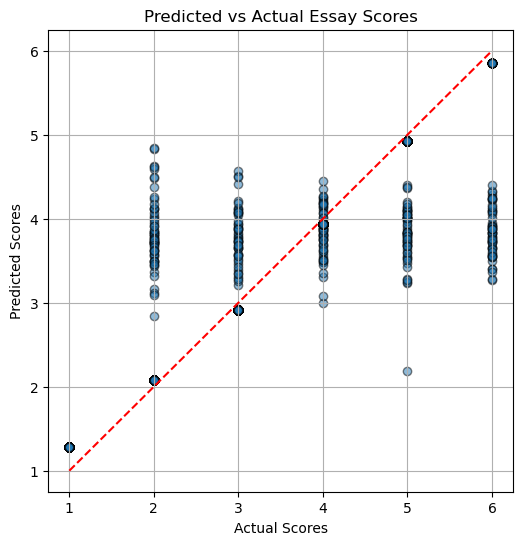

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Predict on validation set
y_pred = model.predict({"text_input": X_val, "lang_input": X_val_lang}).flatten()

# Scatter plot: predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred, alpha=0.5, edgecolors='k')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("Predicted vs Actual Essay Scores")
plt.grid(True)
plt.show()


In [36]:
rounded_preds = np.round(y_pred)
exact = np.mean(rounded_preds == y_val)
within_1 = np.mean(np.abs(rounded_preds - y_val) <= 1)

print(f"Exact Match Accuracy: {exact:.2%}")
print(f"Accuracy Within ±1 Point: {within_1:.2%}")


Exact Match Accuracy: 95.56%
Accuracy Within ±1 Point: 97.75%


In [40]:
# Build validation DataFrame
df_val = full_df.iloc[X_val_idx].copy()
df_val['predicted'] = y_pred
df_val['rounded_pred'] = np.round(y_pred)

# Evaluate per language
lang_eval = df_val.groupby('lang').apply(
    lambda df: pd.Series({
        'Exact Match Accuracy': np.mean(df['rounded_pred'] == df['score']),
        'Within ±1 Accuracy': np.mean(np.abs(df['rounded_pred'] - df['score']) <= 1),
        'Count': len(df)
    })
)

print(lang_eval)



      Exact Match Accuracy  Within ±1 Accuracy   Count
lang                                                  
de                0.170455            0.602273    88.0
en                1.000000            1.000000  4953.0
es                0.238095            0.609524   105.0
fr                0.191919            0.575758    99.0


In [38]:
from sklearn.model_selection import train_test_split

# Get indices first
val_indices = np.arange(len(full_df))
_, X_val_idx = train_test_split(val_indices, test_size=0.2, random_state=42)


In [41]:
lang_counts = full_df['lang'].value_counts()
min_count = lang_counts.min()
print(lang_counts)
print(f"Minimum sample count across languages: {min_count}")


en    24728
de      499
es      499
fr      499
Name: lang, dtype: int64
Minimum sample count across languages: 499


In [42]:
balanced_df = full_df.groupby('lang').sample(n=min_count, random_state=42)
print(balanced_df['lang'].value_counts())  # now all equal


de    499
en    499
es    499
fr    499
Name: lang, dtype: int64
